<a href="https://colab.research.google.com/github/Gape-42/IniciacaoCientifica/blob/main/Algoritmo_Gen%C3%A9tico_IC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bibliotecas

In [ ]:
import random
import math
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import os
from google.colab import drive

Carregando conjunto de dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dados = pd.read_csv("/content/Vertebral.csv")
dados = shuffle(dados)
X = dados.iloc[:,:-1]
Y = dados.iloc[:,-1]

Gerando os conjuntos de treino, teste e validação

In [ ]:
x_treino,x_temp,y_treino,y_temp=train_test_split(X,Y,test_size=0.5,stratify=Y)
x_validacao,x_teste,y_validacao,y_teste=train_test_split(x_temp,y_temp,test_size=0.5, stratify = y_temp)

Constantes

In [ ]:
NUM_INDIVIDUOS = 100
NUM_GERACOES = 100
TAXA_DE_CRUZAMENTO = 0.9 # 0.6 ... 0.9
TAXA_DE_MUTACAO = 0.05 # 0.01 ... 0.05
QUANTIDADE_ELITISMO = math.ceil(NUM_INDIVIDUOS/100)

Definindo os individuos

In [ ]:
class individuos:
  def __init__(self, criterio, profundidade, min_samples_leaf, min_samples_split, splitter, fitness):
    self.criterio = criterio
    self.profundidade = profundidade
    self.min_samples_leaf = min_samples_leaf
    self.min_samples_split = min_samples_split
    self.splitter = splitter
    self.fitness = fitness

Funções

In [ ]:
#Atributos
def rand_criterio():
  return random.choice(["gini", "entropy"]) # 0 Gini, 1 entropy

def rand_profundidade():
  return random.randint(1, 10)

def rand_min_samples_leaf():
  return random.randint(1, 10)

def rand_min_samples_split():
  return random.randint(2, 15)

def rand_splitter():
  return random.choice(["best", "random"]) # 0 best, 1 random

def fitness_inicial():
  return 0

#Elitismo
def elitismo(populacao):
  melhores_individuos = sorted(populacao, key=lambda x: x.fitness, reverse=True)[:QUANTIDADE_ELITISMO]
  return melhores_individuos

#Seleção por roleta
def probabilidade_selecao(populacao):
  soma_fitness = sum(i.fitness for i in populacao)
  probabilidade = []
  for i in populacao:
     probabilidade.append(i.fitness/soma_fitness)
  return probabilidade

def selecao(populacao, probabilidades):
  numero_aleatorio = random.random()
  soma = 0
  individuo = 0
  for i in probabilidades:
    individuo += 1
    soma = soma + i
    if soma >= numero_aleatorio:
      break
  return populacao[individuo-1]

#Cruzamento por média simples
def cruzamento(pai1, pai2):

  if(numero_aleatorio() < TAXA_DE_CRUZAMENTO):
    filho_criterio = random.choice([pai1.criterio, pai2.criterio])
    filho_splitter = random.choice([pai1.splitter, pai2.splitter])
    filho_profundidade = round((pai1.profundidade + pai2.profundidade)/2)
    filho_min_samples_leaf = round((pai1.min_samples_leaf + pai2.min_samples_leaf)/2)
    filho_min_samples_split = round((pai1.min_samples_split + pai2.min_samples_split)/2)

    filho_fitness = 0

    return individuos(filho_criterio, filho_profundidade, filho_min_samples_leaf, filho_min_samples_split, filho_splitter, filho_fitness)
  else:
    return random.choice([pai1, pai2])

#Mutação
def numero_aleatorio():
  return random.random()

def mutacao_aleatoria():
  return random.choice([-1, 1])

def mutacao(individuo):
    if numero_aleatorio() < TAXA_DE_MUTACAO:
      individuo.criterio = rand_criterio()
    if numero_aleatorio() < TAXA_DE_MUTACAO:
      individuo.splitter = rand_splitter()
    if numero_aleatorio() < TAXA_DE_MUTACAO:
      individuo.profundidade += mutacao_aleatoria()
      if individuo.profundidade < 1:
        individuo.profundidade = 1
      if individuo.profundidade > 10:
        individuo.profundidade = 10
    if numero_aleatorio() < TAXA_DE_MUTACAO:
      individuo.min_samples_leaf += mutacao_aleatoria()
      if individuo.min_samples_leaf < 1:
        individuo.min_samples_leaf = 1
      if individuo.min_samples_leaf > 10:
        individuo.min_samples_leaf = 10
    if numero_aleatorio() < TAXA_DE_MUTACAO:
      individuo.min_samples_split += mutacao_aleatoria()
      if individuo.min_samples_split < 2:
        individuo.min_samples_split = 2
      if individuo.min_samples_split > 15:
        individuo.min_samples_split = 15
    return individuo

def arvore_decisao(individuo):
  AD = DecisionTreeClassifier(criterion=individuo.criterio, max_depth=individuo.profundidade, min_samples_leaf=individuo.min_samples_leaf ,min_samples_split=individuo.min_samples_split ,splitter=individuo.splitter)
  AD.fit(x_treino,y_treino)
  opiniao = AD.predict(x_validacao)
  return accuracy_score(y_validacao, opiniao)

def print_populacao(populacao):
  print("Individuo\t Critério\t Profundidade\t Min_samples_leaf\t Min_samples_split\t Splitter\t Fitness")

  for i in range(0, NUM_INDIVIDUOS):
    print(i, "\t\t", end="")
    print(populacao[i].criterio, "   \t\t", end="")
    print(populacao[i].profundidade, "\t\t", end="")
    print(populacao[i].min_samples_leaf, "\t\t\t", end="")
    print(populacao[i].min_samples_split, "\t\t", end="")
    print(populacao[i].splitter, "\t\t\t", end="")
    print(populacao[i].fitness)

def o_melhor(populacao):
  melhor = sorted(populacao, key=lambda x: x.fitness, reverse=True)[:1]
  return melhor[0]

def media_dos_fitness():
  media_fitness = (sum(individuos.fitness for individuos in populacao))/NUM_INDIVIDUOS
  return media_fitness

Criando a primeira população

In [ ]:
populacao = []
populacaoAux = []
melhores_individuos = []
media_fitness = []
melhor_geracao = []

for i in range(0, NUM_INDIVIDUOS):
  populacao.append(individuos(rand_criterio(), rand_profundidade(), rand_min_samples_leaf(), rand_min_samples_split(), rand_splitter(), fitness_inicial()))

  populacao[i].fitness = arvore_decisao(populacao[i])

Seleção, cruzamento e mutação até acabar as gerações

In [ ]:
for j in range (NUM_GERACOES):
  melhor_da_geracao = o_melhor(populacao)
  melhores_individuos.append(melhor_da_geracao)
  melhor_geracao.append(melhor_da_geracao.fitness)
  media_fitness.append(media_dos_fitness())
  populacaoAux = elitismo(populacao).copy()
  for i in range(len(populacao) - QUANTIDADE_ELITISMO):
    probabilidades = probabilidade_selecao(populacao)
    pai1 = selecao(populacao, probabilidades)
    pai2 = selecao(populacao, probabilidades)
    while (pai1 == pai2):
      pai2 = selecao(populacao, probabilidades)
    filho = cruzamento(pai1, pai2)
    filho = mutacao(filho)

    populacaoAux.append(filho)

  populacao = populacaoAux

  for i in range(len(populacao)):
    populacao[i].fitness = arvore_decisao(populacao[i])

  # print_populacao(populacao)

Gerando o gráfico

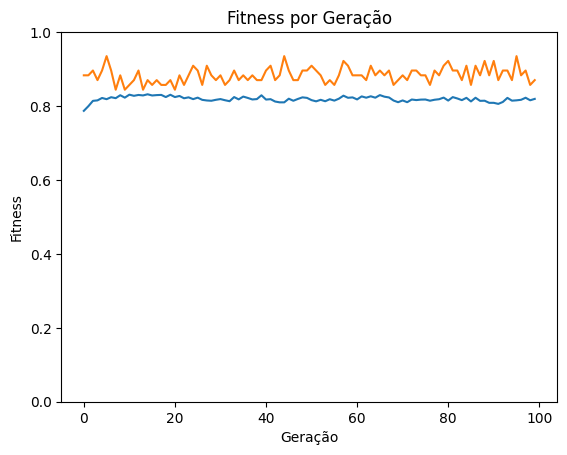

In [ ]:
eixo_geracoes = [0]
for i in range(NUM_GERACOES - 1):
  eixo_geracoes.append(i+1)

plt.title("Fitness por Geração")
plt.xlabel("Geração")
plt.ylabel("Fitness")


plt.ylim([0, 1])


fitness = []
for i in range(NUM_GERACOES):
  fitness.append(melhores_individuos[i].fitness)

# plt.plot(eixo_geracoes, fitness)
plt.plot(eixo_geracoes, media_fitness)
plt.plot(eixo_geracoes, melhor_geracao)

# plt.legend(['Melhor da geração', 'Média da geração'])
plt.show()

In [ ]:
melhor_individuo = o_melhor(melhores_individuos)
print("Melhor individuo\n")
print(f"Critério: \t\t", melhor_individuo.criterio)
print(f"Profundidade: \t\t", melhor_individuo.profundidade)
print(f"Min samples leaf: \t", melhor_individuo.min_samples_leaf)
print(f"Min samples split: \t", melhor_individuo.min_samples_split)
print(f"Splitter: \t\t", melhor_individuo.splitter)
print(f"Fitness: \t\t", melhor_individuo.fitness)

Melhor individuo

Critério: 		 gini
Profundidade: 		 6
Min samples leaf: 	 6
Min samples split: 	 8
Splitter: 		 random
Fitness: 		 0.8961038961038961


Testando a melhor configuração

In [ ]:
def arvore_decisao_teste(individuo):
  AD = DecisionTreeClassifier(criterion=individuo.criterio, max_depth=individuo.profundidade, min_samples_leaf=individuo.min_samples_leaf ,min_samples_split=individuo.min_samples_split ,splitter=individuo.splitter)
  AD.fit(x_treino,y_treino)
  opiniao = AD.predict(x_teste)
  return accuracy_score(y_teste, opiniao)

acuracia = arvore_decisao_teste(melhor_individuo)
print("Acurácia: ", acuracia)

# for i in range(len(melhores_individuos)):
#   melhor = arvore_decisao_teste(melhores_individuos[i])
#   print("Acurácia do melhor individuo: ", melhor)

Acurácia:  0.8461538461538461
